In [1]:
import numpy as np
import pandas as pd 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
from plotly import tools
from plotly.subplots import make_subplots
import plotly.offline as py
from sklearn.cluster import KMeans
from joblib import Parallel, delayed

In [24]:
#gate
#df = pd.read_csv('gate.csv')
#all obstacles
df = pd.read_csv('all_obstacles.csv')
df.head()

,X,Y,Z
0,12.0712,-0.058293,2.21160
1,12.0572,-0.075842,2.20852
2,12.0492,-0.093352,2.20676
3,12.0452,-0.110847,2.20588
4,12.0462,-0.128355,2.20610


Text(0, 0.5, 'Z-axis ')

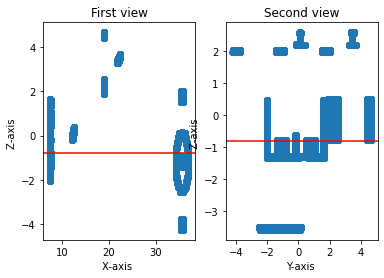

In [25]:
plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.scatter(df['X'],df['Y'])
plt.axhline(y=np.mean(df['Z']), color='r', linestyle='-')
plt.title("First view")
plt.xlabel('X-axis ')
plt.ylabel('Z-axis ')
plt.subplot(1, 2, 2) # index 2
plt.scatter(df['Y'],df['Z'])
plt.axhline(y=np.mean(df['Z']), color='r', linestyle='-')
plt.title("Second view")
plt.xlabel('Y-axis ')
plt.ylabel('Z-axis ')

In [26]:
pcd=np.column_stack((df['X'],df['Y'],df['Z']))
mask=df['Z']>np.mean(df['Z'])
spatial_query=pcd[df['Z']>np.mean(df['Z'])]

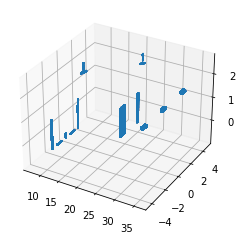

In [27]:
#plotting the results 3D
ax = plt.axes(projection='3d')
ax.scatter(df['X'][mask], df['Y'][mask], df['Z'][mask],s=0.1)
plt.show()

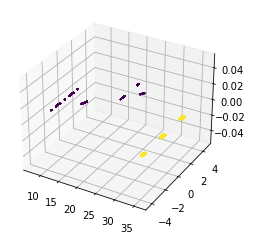

In [28]:
X=np.column_stack((df['X'][mask], df['Y'][mask]))
kmeans = KMeans(n_clusters=2).fit(X)
ax = plt.axes(projection='3d')
ax.scatter(df['X'][mask], df['Y'][mask], c=kmeans.labels_, s=0.1)
plt.show()

In [29]:
X=np.column_stack((df['X'][mask], df['Y'][mask], df['Z'][mask]))
wcss = [] 
for i in range(1, 20):
    kmeans =KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

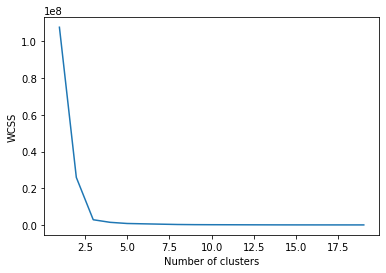

In [30]:
plt.plot(range(1, 20), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') 
plt.show()

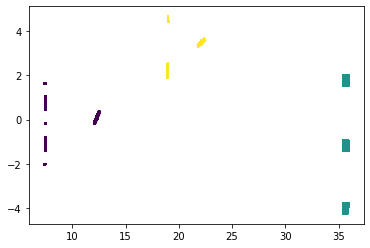

In [31]:
X=np.column_stack((df['X'][mask], df['Y'][mask], df['Z'][mask]))
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
plt.scatter(df['X'][mask], df['Y'][mask], c=kmeans.labels_, s=0.1)
plt.show()

In [32]:
def kMeansRes(scaled_data, k, alpha_k=0.02):
    '''
    Parameters 
    ----------
    scaled_data: matrix 
        scaled data. rows are samples and columns are features for clustering
    k: int
        current k for applying KMeans
    alpha_k: float
        manually tuned factor that gives penalty to the number of clusters
    Returns 
    -------
    scaled_inertia: float
        scaled inertia value for current k           
    '''
    
    inertia_o = np.square((scaled_data - scaled_data.mean(axis=0))).sum()
    # fit k-means
    kmeans = KMeans(n_clusters=k, random_state=0).fit(scaled_data)
    scaled_inertia = kmeans.inertia_ / inertia_o + alpha_k * k
    return scaled_inertia

def chooseBestKforKMeansParallel(scaled_data, k_range):
    '''
    Parameters 
    ----------
    scaled_data: matrix 
        scaled data. rows are samples and columns are features for clustering
    k_range: list of integers
        k range for applying KMeans
    Returns 
    -------
    best_k: int
        chosen value of k out of the given k range.
        chosen k is k with the minimum scaled inertia value.
    results: pandas DataFrame
        adjusted inertia value for each k in k_range
    '''
    
    ans = Parallel(n_jobs=-1,verbose=10)(delayed(kMeansRes)(scaled_data, k) for k in k_range)
    ans = list(zip(k_range,ans))
    results = pd.DataFrame(ans, columns = ['k','Scaled Inertia']).set_index('k')
    best_k = results.idxmin()[0]
    return best_k, results

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.0s finished


([<matplotlib.axis.XTick at 0x2049467f3d0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

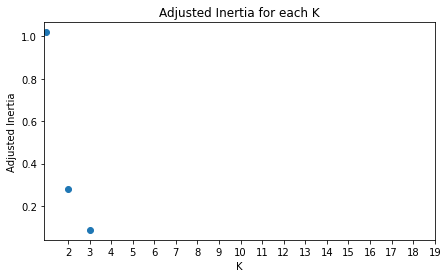

In [33]:
k_range=range(1,4)
best_k, results = chooseBestKforKMeansParallel(X, k_range)

# plot the results
plt.figure(figsize=(7,4))
plt.plot(results,'o')
plt.title('Adjusted Inertia for each K')
plt.xlabel('K')
plt.ylabel('Adjusted Inertia')
plt.xticks(range(2,20,1))

In [ ]:
print(best_k)
kmeans= KMeans(n_clusters=best_k).fit(X)
ax = plt.axes(projection='3d')
ax.scatter(df['X'][mask], df['Y'][mask], c=kmeans.labels_, s=0.1)
plt.show()
print(kmeans.cluster_centers_)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

3
